In [1]:
! pip3 install tensorflow numpy boto3 matplotlib 2>&1 > /dev/null
! mkdir cleaned
! mkdir model

mkdir: cannot create directory ‘model’: File exists


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist

import numpy as np

2023-02-17 10:19:01.241937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-17 10:19:01.374787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-17 10:19:01.374827: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-02-17 10:19:02.320641: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-17 10:19:02.320723: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-17 10:19:02.320734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
import boto3
from boto3 import session
import os

key_id = os.environ.get("AWS_ACCESS_KEY_ID")
secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
bucket_name = os.environ.get("AWS_S3_BUCKET")
s3_endpoint = os.environ.get("AWS_S3_ENDPOINT")

session = boto3.session.Session(aws_access_key_id=key_id, aws_secret_access_key=secret_key)
s3_client = boto3.client("s3", aws_access_key_id=key_id, aws_secret_access_key=secret_key, endpoint_url=s3_endpoint)

In [4]:
s3_client.download_file(bucket_name, "/cleaned/x_train.npy", './cleaned/x_train.npy')
s3_client.download_file(bucket_name, "/cleaned/x_test.npy", './cleaned/x_test.npy')
s3_client.download_file(bucket_name, "/cleaned/x_val.npy", './cleaned/x_val.npy')
s3_client.download_file(bucket_name, "/cleaned/y_train.npy", './cleaned/y_train.npy')
s3_client.download_file(bucket_name, "/cleaned/y_val.npy", './cleaned/y_val.npy')

In [5]:
x_train = np.load('./cleaned/x_train.npy')
x_test = np.load('./cleaned/x_test.npy')
x_val = np.load('./cleaned/x_val.npy')
y_train = np.load('./cleaned/y_train.npy')
y_val = np.load('./cleaned/y_val.npy')

# 4) Define the MPL model

In [6]:
model = Sequential()
model.add(Dense(units=256, activation='relu', input_shape=(784,)))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=10,  activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])
model.summary()

2023-02-17 10:19:04.648538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-17 10:19:04.648570: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-17 10:19:04.648591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (model-0): /proc/driver/nvidia/version does not exist
2023-02-17 10:19:04.648801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 256)               200960    


 dense_1 (Dense)             (None, 256)               65792     


 dense_2 (Dense)             (None, 10)                2570      


Total params: 269,322


Trainable params: 269,322


Non-trainable params: 0


_________________________________________________________________


In [7]:
# create a list to store the accuracy rate
loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]

# 5) Train the model

In [8]:
for epoch in range(0, 20):
    print('epoch', epoch)
    #set epochs=1
    history=model.fit(x_train, y_train, batch_size=64, epochs=1, validation_data=(x_val, y_val))
    loss_train_list.extend(history.history['loss'])
    loss_val_list.extend(history.history['val_loss'])
    acc_train_list.extend(history.history['accuracy'])
    acc_val_list.extend(history.history['val_accuracy'])
    #save the model to a a HDF5 file
    if (epoch+1)%10 == 0:
        model.save('./model/MLP_Keras_e'+str(epoch)+'.h5')

epoch 0


  1/591 [..............................] - ETA: 3:44 - loss: 2.3166 - accuracy: 0.1250

 16/591 [..............................] - ETA: 3s - loss: 2.1683 - accuracy: 0.3008  

 36/591 [>.............................] - ETA: 2s - loss: 1.8062 - accuracy: 0.5165

 58/591 [=>............................] - ETA: 2s - loss: 1.4247 - accuracy: 0.6280

 79/591 [===>..........................] - ETA: 2s - loss: 1.1814 - accuracy: 0.6877

 99/591 [====>.........................] - ETA: 2s - loss: 1.0336 - accuracy: 0.7249

121/591 [=====>........................] - ETA: 2s - loss: 0.9293 - accuracy: 0.7518

143/591 [======>.......................] - ETA: 2s - loss: 0.8478 - accuracy: 0.7715

165/591 [=======>......................] - ETA: 2s - loss: 0.7825 - accuracy: 0.7873

187/591 [========>.....................] - ETA: 1s - loss: 0.7357 - accuracy: 0.7980

191/591 [========>.....................] - ETA: 1s - loss: 0.7261 - accuracy: 0.8004

210/591 [=========>....................] - ETA: 1s - loss: 0.6889 - accuracy: 0.8092

233/591 [==========>...................] - ETA: 1s - loss: 0.6574 - accuracy: 0.8173

256/591 [===========>..................] - ETA: 1s - loss: 0.6284 - accuracy: 0.8253

257/591 [============>.................] - ETA: 1s - loss: 0.6273 - accuracy: 0.8255

280/591 [=============>................] - ETA: 1s - loss: 0.6005 - accuracy: 0.8321

303/591 [==============>...............] - ETA: 1s - loss: 0.5766 - accuracy: 0.8378

327/591 [===============>..............] - ETA: 1s - loss: 0.5557 - accuracy: 0.8435

350/591 [================>.............] - ETA: 1s - loss: 0.5389 - accuracy: 0.8480

374/591 [=================>............] - ETA: 0s - loss: 0.5213 - accuracy: 0.8530

397/591 [===================>..........] - ETA: 0s - loss: 0.5095 - accuracy: 0.8559

398/591 [===================>..........] - ETA: 0s - loss: 0.5088 - accuracy: 0.8560

421/591 [====================>.........] - ETA: 0s - loss: 0.4956 - accuracy: 0.8595

445/591 [=====================>........] - ETA: 0s - loss: 0.4834 - accuracy: 0.8631

467/591 [======================>.......] - ETA: 0s - loss: 0.4717 - accuracy: 0.8660

490/591 [=======================>......] - ETA: 0s - loss: 0.4618 - accuracy: 0.8688

491/591 [=======================>......] - ETA: 0s - loss: 0.4614 - accuracy: 0.8688

514/591 [=========================>....] - ETA: 0s - loss: 0.4537 - accuracy: 0.8707

537/591 [==========================>...] - ETA: 0s - loss: 0.4455 - accuracy: 0.8729

561/591 [===========================>..] - ETA: 0s - loss: 0.4366 - accuracy: 0.8752

584/591 [============================>.] - ETA: 0s - loss: 0.4293 - accuracy: 0.8774

591/591 [==============================] - 3s 5ms/step - loss: 0.4272 - accuracy: 0.8779 - val_loss: 0.2442 - val_accuracy: 0.9310


epoch 1
  1/591 [..............................] - ETA: 2s - loss: 0.1419 - accuracy: 0.9531

 24/591 [>.............................] - ETA: 1s - loss: 0.2241 - accuracy: 0.9316

 28/591 [>.............................] - ETA: 2s - loss: 0.2320 - accuracy: 0.9297

 51/591 [=>............................] - ETA: 2s - loss: 0.2231 - accuracy: 0.9344

 75/591 [==>...........................] - ETA: 2s - loss: 0.2178 - accuracy: 0.9356

 99/591 [====>.........................] - ETA: 2s - loss: 0.2103 - accuracy: 0.9394

122/591 [=====>........................] - ETA: 1s - loss: 0.2085 - accuracy: 0.9389

145/591 [======>.......................] - ETA: 1s - loss: 0.2083 - accuracy: 0.9381

168/591 [=======>......................] - ETA: 1s - loss: 0.2032 - accuracy: 0.9390

192/591 [========>.....................] - ETA: 1s - loss: 0.1984 - accuracy: 0.9403

216/591 [=========>....................] - ETA: 1s - loss: 0.1964 - accuracy: 0.9411

239/591 [===========>..................] - ETA: 1s - loss: 0.1958 - accuracy: 0.9415

262/591 [============>.................] - ETA: 1s - loss: 0.1934 - accuracy: 0.9424

263/591 [============>.................] - ETA: 1s - loss: 0.1932 - accuracy: 0.9425

286/591 [=============>................] - ETA: 1s - loss: 0.1917 - accuracy: 0.9426

309/591 [==============>...............] - ETA: 1s - loss: 0.1903 - accuracy: 0.9429

332/591 [===============>..............] - ETA: 1s - loss: 0.1901 - accuracy: 0.9432

333/591 [===============>..............] - ETA: 1s - loss: 0.1898 - accuracy: 0.9432

357/591 [=================>............] - ETA: 0s - loss: 0.1894 - accuracy: 0.9436

380/591 [==================>...........] - ETA: 0s - loss: 0.1877 - accuracy: 0.9442

404/591 [===================>..........] - ETA: 0s - loss: 0.1884 - accuracy: 0.9440

425/591 [====================>.........] - ETA: 0s - loss: 0.1878 - accuracy: 0.9438

427/591 [====================>.........] - ETA: 0s - loss: 0.1875 - accuracy: 0.9438

450/591 [=====================>........] - ETA: 0s - loss: 0.1868 - accuracy: 0.9442

473/591 [=======================>......] - ETA: 0s - loss: 0.1851 - accuracy: 0.9449

497/591 [========================>.....] - ETA: 0s - loss: 0.1844 - accuracy: 0.9450

518/591 [=========================>....] - ETA: 0s - loss: 0.1826 - accuracy: 0.9457

520/591 [=========================>....] - ETA: 0s - loss: 0.1823 - accuracy: 0.9458

542/591 [==========================>...] - ETA: 0s - loss: 0.1819 - accuracy: 0.9462

566/591 [===========================>..] - ETA: 0s - loss: 0.1816 - accuracy: 0.9463

588/591 [============================>.] - ETA: 0s - loss: 0.1815 - accuracy: 0.9464

590/591 [============================>.] - ETA: 0s - loss: 0.1817 - accuracy: 0.9464

591/591 [==============================] - 3s 5ms/step - loss: 0.1817 - accuracy: 0.9464 - val_loss: 0.1736 - val_accuracy: 0.9483


epoch 2


  1/591 [..............................] - ETA: 2s - loss: 0.0887 - accuracy: 0.9688

 18/591 [..............................] - ETA: 1s - loss: 0.1327 - accuracy: 0.9557

 42/591 [=>............................] - ETA: 2s - loss: 0.1328 - accuracy: 0.9602

 65/591 [==>...........................] - ETA: 2s - loss: 0.1300 - accuracy: 0.9603

 88/591 [===>..........................] - ETA: 2s - loss: 0.1301 - accuracy: 0.9608

111/591 [====>.........................] - ETA: 1s - loss: 0.1328 - accuracy: 0.9590

130/591 [=====>........................] - ETA: 1s - loss: 0.1315 - accuracy: 0.9597

154/591 [======>.......................] - ETA: 1s - loss: 0.1326 - accuracy: 0.9599

156/591 [======>.......................] - ETA: 1s - loss: 0.1325 - accuracy: 0.9601

177/591 [=======>......................] - ETA: 1s - loss: 0.1321 - accuracy: 0.9607

200/591 [=========>....................] - ETA: 1s - loss: 0.1320 - accuracy: 0.9603

223/591 [==========>...................] - ETA: 1s - loss: 0.1340 - accuracy: 0.9602

246/591 [===========>..................] - ETA: 1s - loss: 0.1330 - accuracy: 0.9605

270/591 [============>.................] - ETA: 1s - loss: 0.1318 - accuracy: 0.9608

293/591 [=============>................] - ETA: 1s - loss: 0.1320 - accuracy: 0.9609

316/591 [===============>..............] - ETA: 1s - loss: 0.1318 - accuracy: 0.9608

318/591 [===============>..............] - ETA: 1s - loss: 0.1314 - accuracy: 0.9610

341/591 [================>.............] - ETA: 1s - loss: 0.1323 - accuracy: 0.9608

364/591 [=================>............] - ETA: 0s - loss: 0.1328 - accuracy: 0.9605

387/591 [==================>...........] - ETA: 0s - loss: 0.1316 - accuracy: 0.9609

411/591 [===================>..........] - ETA: 0s - loss: 0.1310 - accuracy: 0.9611

435/591 [=====================>........] - ETA: 0s - loss: 0.1299 - accuracy: 0.9614

458/591 [======================>.......] - ETA: 0s - loss: 0.1297 - accuracy: 0.9616

475/591 [=======================>......] - ETA: 0s - loss: 0.1293 - accuracy: 0.9618

490/591 [=======================>......] - ETA: 0s - loss: 0.1285 - accuracy: 0.9619

505/591 [========================>.....] - ETA: 0s - loss: 0.1286 - accuracy: 0.9620

518/591 [=========================>....] - ETA: 0s - loss: 0.1286 - accuracy: 0.9620

532/591 [==========================>...] - ETA: 0s - loss: 0.1280 - accuracy: 0.9623

547/591 [==========================>...] - ETA: 0s - loss: 0.1277 - accuracy: 0.9624

560/591 [===========================>..] - ETA: 0s - loss: 0.1278 - accuracy: 0.9624

574/591 [============================>.] - ETA: 0s - loss: 0.1275 - accuracy: 0.9624

589/591 [============================>.] - ETA: 0s - loss: 0.1268 - accuracy: 0.9626

591/591 [==============================] - 3s 5ms/step - loss: 0.1268 - accuracy: 0.9626 - val_loss: 0.1384 - val_accuracy: 0.9593


epoch 3
  1/591 [..............................] - ETA: 2s - loss: 0.1048 - accuracy: 0.9531

  4/591 [..............................] - ETA: 9s - loss: 0.1481 - accuracy: 0.9453

 17/591 [..............................] - ETA: 5s - loss: 0.1106 - accuracy: 0.9623

 32/591 [>.............................] - ETA: 4s - loss: 0.1018 - accuracy: 0.9683

 46/591 [=>............................] - ETA: 4s - loss: 0.0945 - accuracy: 0.9708

 61/591 [==>...........................] - ETA: 3s - loss: 0.1011 - accuracy: 0.9693

 75/591 [==>...........................] - ETA: 3s - loss: 0.0967 - accuracy: 0.9712

 90/591 [===>..........................] - ETA: 3s - loss: 0.1028 - accuracy: 0.9691

104/591 [====>.........................] - ETA: 3s - loss: 0.1022 - accuracy: 0.9686

119/591 [=====>........................] - ETA: 3s - loss: 0.1006 - accuracy: 0.9691

133/591 [=====>........................] - ETA: 3s - loss: 0.0978 - accuracy: 0.9706

147/591 [======>.......................] - ETA: 3s - loss: 0.0965 - accuracy: 0.9709

161/591 [=======>......................] - ETA: 3s - loss: 0.0949 - accuracy: 0.9711

175/591 [=======>......................] - ETA: 2s - loss: 0.0928 - accuracy: 0.9721

189/591 [========>.....................] - ETA: 2s - loss: 0.0928 - accuracy: 0.9721

202/591 [=========>....................] - ETA: 2s - loss: 0.0937 - accuracy: 0.9717

215/591 [=========>....................] - ETA: 2s - loss: 0.0951 - accuracy: 0.9713

229/591 [==========>...................] - ETA: 2s - loss: 0.0948 - accuracy: 0.9713

244/591 [===========>..................] - ETA: 2s - loss: 0.0953 - accuracy: 0.9710

258/591 [============>.................] - ETA: 2s - loss: 0.0960 - accuracy: 0.9706

272/591 [============>.................] - ETA: 2s - loss: 0.0958 - accuracy: 0.9707

286/591 [=============>................] - ETA: 2s - loss: 0.0972 - accuracy: 0.9704

299/591 [==============>...............] - ETA: 2s - loss: 0.0966 - accuracy: 0.9706

313/591 [==============>...............] - ETA: 2s - loss: 0.0977 - accuracy: 0.9705

327/591 [===============>..............] - ETA: 1s - loss: 0.0975 - accuracy: 0.9706

342/591 [================>.............] - ETA: 1s - loss: 0.0978 - accuracy: 0.9704

350/591 [================>.............] - ETA: 1s - loss: 0.0973 - accuracy: 0.9705

351/591 [================>.............] - ETA: 1s - loss: 0.0977 - accuracy: 0.9705

366/591 [=================>............] - ETA: 1s - loss: 0.0979 - accuracy: 0.9701

380/591 [==================>...........] - ETA: 1s - loss: 0.0975 - accuracy: 0.9702

394/591 [===================>..........] - ETA: 1s - loss: 0.0970 - accuracy: 0.9705

409/591 [===================>..........] - ETA: 1s - loss: 0.0969 - accuracy: 0.9705

423/591 [====================>.........] - ETA: 1s - loss: 0.0970 - accuracy: 0.9703

438/591 [=====================>........] - ETA: 1s - loss: 0.0974 - accuracy: 0.9703

451/591 [=====================>........] - ETA: 1s - loss: 0.0969 - accuracy: 0.9705

466/591 [======================>.......] - ETA: 0s - loss: 0.0971 - accuracy: 0.9704

480/591 [=======================>......] - ETA: 0s - loss: 0.0966 - accuracy: 0.9706

495/591 [========================>.....] - ETA: 0s - loss: 0.0962 - accuracy: 0.9708

509/591 [========================>.....] - ETA: 0s - loss: 0.0958 - accuracy: 0.9708

524/591 [=========================>....] - ETA: 0s - loss: 0.0949 - accuracy: 0.9711

539/591 [==========================>...] - ETA: 0s - loss: 0.0947 - accuracy: 0.9711

553/591 [===========================>..] - ETA: 0s - loss: 0.0945 - accuracy: 0.9712

568/591 [===========================>..] - ETA: 0s - loss: 0.0940 - accuracy: 0.9714

582/591 [============================>.] - ETA: 0s - loss: 0.0949 - accuracy: 0.9712

591/591 [==============================] - 4s 8ms/step - loss: 0.0951 - accuracy: 0.9711 - val_loss: 0.1308 - val_accuracy: 0.9631


epoch 4
  1/591 [..............................] - ETA: 23s - loss: 0.1075 - accuracy: 0.9688

 15/591 [..............................] - ETA: 4s - loss: 0.0739 - accuracy: 0.9781 

 29/591 [>.............................] - ETA: 4s - loss: 0.0704 - accuracy: 0.9817

 43/591 [=>............................] - ETA: 3s - loss: 0.0726 - accuracy: 0.9797

 58/591 [=>............................] - ETA: 3s - loss: 0.0702 - accuracy: 0.9801

 72/591 [==>...........................] - ETA: 3s - loss: 0.0708 - accuracy: 0.9811

 87/591 [===>..........................] - ETA: 3s - loss: 0.0739 - accuracy: 0.9804

101/591 [====>.........................] - ETA: 3s - loss: 0.0744 - accuracy: 0.9799

113/591 [====>.........................] - ETA: 3s - loss: 0.0746 - accuracy: 0.9795

128/591 [=====>........................] - ETA: 3s - loss: 0.0757 - accuracy: 0.9797

141/591 [======>.......................] - ETA: 3s - loss: 0.0790 - accuracy: 0.9786

156/591 [======>.......................] - ETA: 3s - loss: 0.0808 - accuracy: 0.9784

170/591 [=======>......................] - ETA: 2s - loss: 0.0809 - accuracy: 0.9781

185/591 [========>.....................] - ETA: 2s - loss: 0.0798 - accuracy: 0.9784

200/591 [=========>....................] - ETA: 2s - loss: 0.0801 - accuracy: 0.9784

214/591 [=========>....................] - ETA: 2s - loss: 0.0790 - accuracy: 0.9787

228/591 [==========>...................] - ETA: 2s - loss: 0.0777 - accuracy: 0.9792

243/591 [===========>..................] - ETA: 2s - loss: 0.0778 - accuracy: 0.9788

257/591 [============>.................] - ETA: 2s - loss: 0.0782 - accuracy: 0.9787

271/591 [============>.................] - ETA: 2s - loss: 0.0771 - accuracy: 0.9789

287/591 [=============>................] - ETA: 2s - loss: 0.0765 - accuracy: 0.9790

305/591 [==============>...............] - ETA: 1s - loss: 0.0763 - accuracy: 0.9791

322/591 [===============>..............] - ETA: 1s - loss: 0.0771 - accuracy: 0.9786

341/591 [================>.............] - ETA: 1s - loss: 0.0778 - accuracy: 0.9783

359/591 [=================>............] - ETA: 1s - loss: 0.0780 - accuracy: 0.9778

377/591 [==================>...........] - ETA: 1s - loss: 0.0782 - accuracy: 0.9774

393/591 [==================>...........] - ETA: 1s - loss: 0.0786 - accuracy: 0.9772

410/591 [===================>..........] - ETA: 1s - loss: 0.0783 - accuracy: 0.9774

427/591 [====================>.........] - ETA: 1s - loss: 0.0777 - accuracy: 0.9776

446/591 [=====================>........] - ETA: 0s - loss: 0.0786 - accuracy: 0.9773

464/591 [======================>.......] - ETA: 0s - loss: 0.0783 - accuracy: 0.9775

481/591 [=======================>......] - ETA: 0s - loss: 0.0777 - accuracy: 0.9777

500/591 [========================>.....] - ETA: 0s - loss: 0.0770 - accuracy: 0.9779

514/591 [=========================>....] - ETA: 0s - loss: 0.0769 - accuracy: 0.9779

532/591 [==========================>...] - ETA: 0s - loss: 0.0768 - accuracy: 0.9778

551/591 [==========================>...] - ETA: 0s - loss: 0.0764 - accuracy: 0.9780

569/591 [===========================>..] - ETA: 0s - loss: 0.0762 - accuracy: 0.9779

587/591 [============================>.] - ETA: 0s - loss: 0.0762 - accuracy: 0.9780

591/591 [==============================] - 4s 7ms/step - loss: 0.0761 - accuracy: 0.9780 - val_loss: 0.1204 - val_accuracy: 0.9645


epoch 5
  1/591 [..............................] - ETA: 2s - loss: 0.0503 - accuracy: 0.9844

 11/591 [..............................] - ETA: 3s - loss: 0.0525 - accuracy: 0.9858

 30/591 [>.............................] - ETA: 3s - loss: 0.0514 - accuracy: 0.9865

 49/591 [=>............................] - ETA: 2s - loss: 0.0564 - accuracy: 0.9853

 67/591 [==>...........................] - ETA: 2s - loss: 0.0543 - accuracy: 0.9855

 85/591 [===>..........................] - ETA: 2s - loss: 0.0546 - accuracy: 0.9858

103/591 [====>.........................] - ETA: 2s - loss: 0.0546 - accuracy: 0.9859

122/591 [=====>........................] - ETA: 2s - loss: 0.0557 - accuracy: 0.9851

140/591 [======>.......................] - ETA: 2s - loss: 0.0557 - accuracy: 0.9852

158/591 [=======>......................] - ETA: 2s - loss: 0.0575 - accuracy: 0.9840

177/591 [=======>......................] - ETA: 2s - loss: 0.0585 - accuracy: 0.9831

196/591 [========>.....................] - ETA: 2s - loss: 0.0591 - accuracy: 0.9831

215/591 [=========>....................] - ETA: 2s - loss: 0.0613 - accuracy: 0.9828

233/591 [==========>...................] - ETA: 1s - loss: 0.0611 - accuracy: 0.9828

250/591 [===========>..................] - ETA: 1s - loss: 0.0626 - accuracy: 0.9827

269/591 [============>.................] - ETA: 1s - loss: 0.0629 - accuracy: 0.9827

283/591 [=============>................] - ETA: 1s - loss: 0.0634 - accuracy: 0.9826

299/591 [==============>...............] - ETA: 1s - loss: 0.0624 - accuracy: 0.9829

316/591 [===============>..............] - ETA: 1s - loss: 0.0614 - accuracy: 0.9831

330/591 [===============>..............] - ETA: 1s - loss: 0.0619 - accuracy: 0.9830

345/591 [================>.............] - ETA: 1s - loss: 0.0623 - accuracy: 0.9831

360/591 [=================>............] - ETA: 1s - loss: 0.0628 - accuracy: 0.9829

377/591 [==================>...........] - ETA: 1s - loss: 0.0625 - accuracy: 0.9829

396/591 [===================>..........] - ETA: 1s - loss: 0.0621 - accuracy: 0.9829

413/591 [===================>..........] - ETA: 1s - loss: 0.0617 - accuracy: 0.9828

431/591 [====================>.........] - ETA: 0s - loss: 0.0619 - accuracy: 0.9827

449/591 [=====================>........] - ETA: 0s - loss: 0.0620 - accuracy: 0.9828

464/591 [======================>.......] - ETA: 0s - loss: 0.0622 - accuracy: 0.9825

478/591 [=======================>......] - ETA: 0s - loss: 0.0622 - accuracy: 0.9824

495/591 [========================>.....] - ETA: 0s - loss: 0.0624 - accuracy: 0.9823

514/591 [=========================>....] - ETA: 0s - loss: 0.0621 - accuracy: 0.9825

533/591 [==========================>...] - ETA: 0s - loss: 0.0619 - accuracy: 0.9826

551/591 [==========================>...] - ETA: 0s - loss: 0.0620 - accuracy: 0.9825

569/591 [===========================>..] - ETA: 0s - loss: 0.0622 - accuracy: 0.9825

588/591 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9825

591/591 [==============================] - 4s 6ms/step - loss: 0.0622 - accuracy: 0.9824 - val_loss: 0.1142 - val_accuracy: 0.9669


epoch 6
  1/591 [..............................] - ETA: 2s - loss: 0.0216 - accuracy: 0.9844

 12/591 [..............................] - ETA: 3s - loss: 0.0526 - accuracy: 0.9883

 31/591 [>.............................] - ETA: 3s - loss: 0.0512 - accuracy: 0.9864

 49/591 [=>............................] - ETA: 3s - loss: 0.0499 - accuracy: 0.9872

 67/591 [==>...........................] - ETA: 2s - loss: 0.0493 - accuracy: 0.9876

 86/591 [===>..........................] - ETA: 2s - loss: 0.0498 - accuracy: 0.9869

103/591 [====>.........................] - ETA: 2s - loss: 0.0545 - accuracy: 0.9842

121/591 [=====>........................] - ETA: 2s - loss: 0.0521 - accuracy: 0.9850

140/591 [======>.......................] - ETA: 2s - loss: 0.0511 - accuracy: 0.9858

158/591 [=======>......................] - ETA: 2s - loss: 0.0533 - accuracy: 0.9848

173/591 [=======>......................] - ETA: 2s - loss: 0.0537 - accuracy: 0.9846

189/591 [========>.....................] - ETA: 2s - loss: 0.0521 - accuracy: 0.9853

202/591 [=========>....................] - ETA: 2s - loss: 0.0526 - accuracy: 0.9852

221/591 [==========>...................] - ETA: 2s - loss: 0.0521 - accuracy: 0.9852

239/591 [===========>..................] - ETA: 2s - loss: 0.0517 - accuracy: 0.9852

258/591 [============>.................] - ETA: 1s - loss: 0.0509 - accuracy: 0.9855

276/591 [=============>................] - ETA: 1s - loss: 0.0507 - accuracy: 0.9856

295/591 [=============>................] - ETA: 1s - loss: 0.0501 - accuracy: 0.9858

313/591 [==============>...............] - ETA: 1s - loss: 0.0510 - accuracy: 0.9858

331/591 [===============>..............] - ETA: 1s - loss: 0.0502 - accuracy: 0.9860

350/591 [================>.............] - ETA: 1s - loss: 0.0492 - accuracy: 0.9862

368/591 [=================>............] - ETA: 1s - loss: 0.0498 - accuracy: 0.9861

385/591 [==================>...........] - ETA: 1s - loss: 0.0494 - accuracy: 0.9862

403/591 [===================>..........] - ETA: 1s - loss: 0.0494 - accuracy: 0.9861

422/591 [====================>.........] - ETA: 0s - loss: 0.0492 - accuracy: 0.9862

440/591 [=====================>........] - ETA: 0s - loss: 0.0495 - accuracy: 0.9859

459/591 [======================>.......] - ETA: 0s - loss: 0.0492 - accuracy: 0.9859

477/591 [=======================>......] - ETA: 0s - loss: 0.0500 - accuracy: 0.9857

495/591 [========================>.....] - ETA: 0s - loss: 0.0498 - accuracy: 0.9857

514/591 [=========================>....] - ETA: 0s - loss: 0.0500 - accuracy: 0.9856

533/591 [==========================>...] - ETA: 0s - loss: 0.0500 - accuracy: 0.9855

551/591 [==========================>...] - ETA: 0s - loss: 0.0498 - accuracy: 0.9856

568/591 [===========================>..] - ETA: 0s - loss: 0.0498 - accuracy: 0.9857

587/591 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9855

591/591 [==============================] - 3s 6ms/step - loss: 0.0499 - accuracy: 0.9856 - val_loss: 0.1060 - val_accuracy: 0.9712


epoch 7
  1/591 [..............................] - ETA: 2s - loss: 0.0275 - accuracy: 1.0000

 12/591 [..............................] - ETA: 3s - loss: 0.0286 - accuracy: 0.9948

 29/591 [>.............................] - ETA: 3s - loss: 0.0419 - accuracy: 0.9887

 48/591 [=>............................] - ETA: 3s - loss: 0.0407 - accuracy: 0.9896

 65/591 [==>...........................] - ETA: 2s - loss: 0.0429 - accuracy: 0.9877

 83/591 [===>..........................] - ETA: 2s - loss: 0.0407 - accuracy: 0.9889

101/591 [====>.........................] - ETA: 2s - loss: 0.0380 - accuracy: 0.9901

118/591 [====>.........................] - ETA: 2s - loss: 0.0386 - accuracy: 0.9899

137/591 [=====>........................] - ETA: 2s - loss: 0.0385 - accuracy: 0.9902

155/591 [======>.......................] - ETA: 2s - loss: 0.0366 - accuracy: 0.9907

174/591 [=======>......................] - ETA: 2s - loss: 0.0371 - accuracy: 0.9907

192/591 [========>.....................] - ETA: 2s - loss: 0.0376 - accuracy: 0.9899

210/591 [=========>....................] - ETA: 2s - loss: 0.0377 - accuracy: 0.9899

230/591 [==========>...................] - ETA: 1s - loss: 0.0382 - accuracy: 0.9895

254/591 [===========>..................] - ETA: 1s - loss: 0.0387 - accuracy: 0.9894

255/591 [===========>..................] - ETA: 1s - loss: 0.0388 - accuracy: 0.9894

278/591 [=============>................] - ETA: 1s - loss: 0.0388 - accuracy: 0.9897

302/591 [==============>...............] - ETA: 1s - loss: 0.0378 - accuracy: 0.9898

326/591 [===============>..............] - ETA: 1s - loss: 0.0379 - accuracy: 0.9895

346/591 [================>.............] - ETA: 1s - loss: 0.0395 - accuracy: 0.9892

368/591 [=================>............] - ETA: 1s - loss: 0.0398 - accuracy: 0.9892

392/591 [==================>...........] - ETA: 0s - loss: 0.0397 - accuracy: 0.9891

416/591 [====================>.........] - ETA: 0s - loss: 0.0401 - accuracy: 0.9888

440/591 [=====================>........] - ETA: 0s - loss: 0.0401 - accuracy: 0.9886

464/591 [======================>.......] - ETA: 0s - loss: 0.0397 - accuracy: 0.9887

487/591 [=======================>......] - ETA: 0s - loss: 0.0394 - accuracy: 0.9889

510/591 [========================>.....] - ETA: 0s - loss: 0.0398 - accuracy: 0.9889

511/591 [========================>.....] - ETA: 0s - loss: 0.0398 - accuracy: 0.9889

535/591 [==========================>...] - ETA: 0s - loss: 0.0408 - accuracy: 0.9886

558/591 [===========================>..] - ETA: 0s - loss: 0.0412 - accuracy: 0.9884

581/591 [============================>.] - ETA: 0s - loss: 0.0410 - accuracy: 0.9883

585/591 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9883

591/591 [==============================] - 3s 5ms/step - loss: 0.0413 - accuracy: 0.9882 - val_loss: 0.1060 - val_accuracy: 0.9686


epoch 8


  1/591 [..............................] - ETA: 2s - loss: 0.1440 - accuracy: 0.9531

 19/591 [..............................] - ETA: 1s - loss: 0.0478 - accuracy: 0.9901

 43/591 [=>............................] - ETA: 1s - loss: 0.0377 - accuracy: 0.9906

 66/591 [==>...........................] - ETA: 2s - loss: 0.0358 - accuracy: 0.9910

 90/591 [===>..........................] - ETA: 1s - loss: 0.0335 - accuracy: 0.9917

113/591 [====>.........................] - ETA: 1s - loss: 0.0361 - accuracy: 0.9909

135/591 [=====>........................] - ETA: 1s - loss: 0.0349 - accuracy: 0.9911

154/591 [======>.......................] - ETA: 1s - loss: 0.0353 - accuracy: 0.9912

171/591 [=======>......................] - ETA: 1s - loss: 0.0340 - accuracy: 0.9919

190/591 [========>.....................] - ETA: 1s - loss: 0.0339 - accuracy: 0.9918

208/591 [=========>....................] - ETA: 1s - loss: 0.0334 - accuracy: 0.9920

226/591 [==========>...................] - ETA: 1s - loss: 0.0330 - accuracy: 0.9920

245/591 [===========>..................] - ETA: 1s - loss: 0.0334 - accuracy: 0.9916

263/591 [============>.................] - ETA: 1s - loss: 0.0331 - accuracy: 0.9917

282/591 [=============>................] - ETA: 1s - loss: 0.0337 - accuracy: 0.9915

302/591 [==============>...............] - ETA: 1s - loss: 0.0341 - accuracy: 0.9912

324/591 [===============>..............] - ETA: 1s - loss: 0.0343 - accuracy: 0.9912

345/591 [================>.............] - ETA: 1s - loss: 0.0351 - accuracy: 0.9909

369/591 [=================>............] - ETA: 1s - loss: 0.0352 - accuracy: 0.9908

393/591 [==================>...........] - ETA: 0s - loss: 0.0349 - accuracy: 0.9908

417/591 [====================>.........] - ETA: 0s - loss: 0.0344 - accuracy: 0.9908

441/591 [=====================>........] - ETA: 0s - loss: 0.0345 - accuracy: 0.9908

463/591 [======================>.......] - ETA: 0s - loss: 0.0345 - accuracy: 0.9907

487/591 [=======================>......] - ETA: 0s - loss: 0.0348 - accuracy: 0.9906

489/591 [=======================>......] - ETA: 0s - loss: 0.0348 - accuracy: 0.9905

511/591 [========================>.....] - ETA: 0s - loss: 0.0350 - accuracy: 0.9905

534/591 [==========================>...] - ETA: 0s - loss: 0.0347 - accuracy: 0.9906

555/591 [===========================>..] - ETA: 0s - loss: 0.0345 - accuracy: 0.9907

577/591 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9907

591/591 [==============================] - 3s 5ms/step - loss: 0.0341 - accuracy: 0.9908 - val_loss: 0.1044 - val_accuracy: 0.9695


epoch 9


  1/591 [..............................] - ETA: 2s - loss: 0.0213 - accuracy: 0.9844

 25/591 [>.............................] - ETA: 1s - loss: 0.0270 - accuracy: 0.9906

 27/591 [>.............................] - ETA: 2s - loss: 0.0275 - accuracy: 0.9907

 50/591 [=>............................] - ETA: 2s - loss: 0.0259 - accuracy: 0.9925

 74/591 [==>...........................] - ETA: 2s - loss: 0.0250 - accuracy: 0.9939

 98/591 [===>..........................] - ETA: 2s - loss: 0.0249 - accuracy: 0.9936

122/591 [=====>........................] - ETA: 1s - loss: 0.0247 - accuracy: 0.9935

146/591 [======>.......................] - ETA: 1s - loss: 0.0255 - accuracy: 0.9933

170/591 [=======>......................] - ETA: 1s - loss: 0.0268 - accuracy: 0.9930

194/591 [========>.....................] - ETA: 1s - loss: 0.0268 - accuracy: 0.9929

196/591 [========>.....................] - ETA: 1s - loss: 0.0269 - accuracy: 0.9929

218/591 [==========>...................] - ETA: 1s - loss: 0.0269 - accuracy: 0.9928

242/591 [===========>..................] - ETA: 1s - loss: 0.0269 - accuracy: 0.9926

243/591 [===========>..................] - ETA: 1s - loss: 0.0269 - accuracy: 0.9926

266/591 [============>.................] - ETA: 1s - loss: 0.0270 - accuracy: 0.9926

290/591 [=============>................] - ETA: 1s - loss: 0.0263 - accuracy: 0.9927

291/591 [=============>................] - ETA: 1s - loss: 0.0263 - accuracy: 0.9927

314/591 [==============>...............] - ETA: 1s - loss: 0.0263 - accuracy: 0.9927

337/591 [================>.............] - ETA: 1s - loss: 0.0273 - accuracy: 0.9922

361/591 [=================>............] - ETA: 0s - loss: 0.0276 - accuracy: 0.9921

362/591 [=================>............] - ETA: 0s - loss: 0.0277 - accuracy: 0.9920

383/591 [==================>...........] - ETA: 0s - loss: 0.0276 - accuracy: 0.9920

403/591 [===================>..........] - ETA: 0s - loss: 0.0277 - accuracy: 0.9919

422/591 [====================>.........] - ETA: 0s - loss: 0.0282 - accuracy: 0.9918

445/591 [=====================>........] - ETA: 0s - loss: 0.0284 - accuracy: 0.9919

468/591 [======================>.......] - ETA: 0s - loss: 0.0288 - accuracy: 0.9918

492/591 [=======================>......] - ETA: 0s - loss: 0.0291 - accuracy: 0.9916

515/591 [=========================>....] - ETA: 0s - loss: 0.0298 - accuracy: 0.9914

539/591 [==========================>...] - ETA: 0s - loss: 0.0299 - accuracy: 0.9914

563/591 [===========================>..] - ETA: 0s - loss: 0.0302 - accuracy: 0.9913

587/591 [============================>.] - ETA: 0s - loss: 0.0300 - accuracy: 0.9914

591/591 [==============================] - 3s 4ms/step - loss: 0.0300 - accuracy: 0.9914 - val_loss: 0.0994 - val_accuracy: 0.9710


epoch 10


  1/591 [..............................] - ETA: 2s - loss: 0.0046 - accuracy: 1.0000

 24/591 [>.............................] - ETA: 1s - loss: 0.0223 - accuracy: 0.9961

 41/591 [=>............................] - ETA: 1s - loss: 0.0203 - accuracy: 0.9966

 65/591 [==>...........................] - ETA: 1s - loss: 0.0229 - accuracy: 0.9952

 89/591 [===>..........................] - ETA: 1s - loss: 0.0222 - accuracy: 0.9953

112/591 [====>.........................] - ETA: 1s - loss: 0.0217 - accuracy: 0.9948

136/591 [=====>........................] - ETA: 1s - loss: 0.0225 - accuracy: 0.9947

160/591 [=======>......................] - ETA: 1s - loss: 0.0224 - accuracy: 0.9947

183/591 [========>.....................] - ETA: 1s - loss: 0.0219 - accuracy: 0.9950

185/591 [========>.....................] - ETA: 1s - loss: 0.0219 - accuracy: 0.9950

207/591 [=========>....................] - ETA: 1s - loss: 0.0225 - accuracy: 0.9945

231/591 [==========>...................] - ETA: 1s - loss: 0.0226 - accuracy: 0.9945

253/591 [===========>..................] - ETA: 1s - loss: 0.0226 - accuracy: 0.9944

254/591 [===========>..................] - ETA: 1s - loss: 0.0226 - accuracy: 0.9944

278/591 [=============>................] - ETA: 1s - loss: 0.0236 - accuracy: 0.9940

301/591 [==============>...............] - ETA: 1s - loss: 0.0240 - accuracy: 0.9939

302/591 [==============>...............] - ETA: 1s - loss: 0.0239 - accuracy: 0.9939

325/591 [===============>..............] - ETA: 1s - loss: 0.0235 - accuracy: 0.9939

348/591 [================>.............] - ETA: 1s - loss: 0.0238 - accuracy: 0.9939

372/591 [=================>............] - ETA: 0s - loss: 0.0233 - accuracy: 0.9941

396/591 [===================>..........] - ETA: 0s - loss: 0.0235 - accuracy: 0.9942

419/591 [====================>.........] - ETA: 0s - loss: 0.0234 - accuracy: 0.9941

442/591 [=====================>........] - ETA: 0s - loss: 0.0235 - accuracy: 0.9940

444/591 [=====================>........] - ETA: 0s - loss: 0.0235 - accuracy: 0.9940

467/591 [======================>.......] - ETA: 0s - loss: 0.0236 - accuracy: 0.9940

490/591 [=======================>......] - ETA: 0s - loss: 0.0234 - accuracy: 0.9940

514/591 [=========================>....] - ETA: 0s - loss: 0.0239 - accuracy: 0.9940

538/591 [==========================>...] - ETA: 0s - loss: 0.0244 - accuracy: 0.9938

562/591 [===========================>..] - ETA: 0s - loss: 0.0240 - accuracy: 0.9940

586/591 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9941

591/591 [==============================] - 3s 4ms/step - loss: 0.0238 - accuracy: 0.9941 - val_loss: 0.0961 - val_accuracy: 0.9721


epoch 11


  1/591 [..............................] - ETA: 1s - loss: 0.0065 - accuracy: 1.0000

 20/591 [>.............................] - ETA: 1s - loss: 0.0165 - accuracy: 0.9977

 44/591 [=>............................] - ETA: 2s - loss: 0.0176 - accuracy: 0.9968

 68/591 [==>...........................] - ETA: 2s - loss: 0.0182 - accuracy: 0.9959

 92/591 [===>..........................] - ETA: 1s - loss: 0.0188 - accuracy: 0.9954

115/591 [====>.........................] - ETA: 1s - loss: 0.0186 - accuracy: 0.9958

139/591 [======>.......................] - ETA: 1s - loss: 0.0195 - accuracy: 0.9958

163/591 [=======>......................] - ETA: 1s - loss: 0.0184 - accuracy: 0.9961

185/591 [========>.....................] - ETA: 1s - loss: 0.0181 - accuracy: 0.9961

209/591 [=========>....................] - ETA: 1s - loss: 0.0180 - accuracy: 0.9962

210/591 [=========>....................] - ETA: 1s - loss: 0.0180 - accuracy: 0.9962

232/591 [==========>...................] - ETA: 1s - loss: 0.0181 - accuracy: 0.9963

236/591 [==========>...................] - ETA: 1s - loss: 0.0182 - accuracy: 0.9962

257/591 [============>.................] - ETA: 1s - loss: 0.0181 - accuracy: 0.9962

281/591 [=============>................] - ETA: 1s - loss: 0.0177 - accuracy: 0.9965

304/591 [==============>...............] - ETA: 1s - loss: 0.0177 - accuracy: 0.9966

305/591 [==============>...............] - ETA: 1s - loss: 0.0177 - accuracy: 0.9966

329/591 [===============>..............] - ETA: 1s - loss: 0.0177 - accuracy: 0.9965

330/591 [===============>..............] - ETA: 1s - loss: 0.0178 - accuracy: 0.9964

353/591 [================>.............] - ETA: 0s - loss: 0.0178 - accuracy: 0.9966

377/591 [==================>...........] - ETA: 0s - loss: 0.0181 - accuracy: 0.9964

401/591 [===================>..........] - ETA: 0s - loss: 0.0187 - accuracy: 0.9963

424/591 [====================>.........] - ETA: 0s - loss: 0.0187 - accuracy: 0.9962

448/591 [=====================>........] - ETA: 0s - loss: 0.0188 - accuracy: 0.9962

472/591 [======================>.......] - ETA: 0s - loss: 0.0185 - accuracy: 0.9963

474/591 [=======================>......] - ETA: 0s - loss: 0.0185 - accuracy: 0.9963

496/591 [========================>.....] - ETA: 0s - loss: 0.0185 - accuracy: 0.9963

519/591 [=========================>....] - ETA: 0s - loss: 0.0187 - accuracy: 0.9963

543/591 [==========================>...] - ETA: 0s - loss: 0.0187 - accuracy: 0.9962

544/591 [==========================>...] - ETA: 0s - loss: 0.0187 - accuracy: 0.9962

563/591 [===========================>..] - ETA: 0s - loss: 0.0188 - accuracy: 0.9961

587/591 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9961

588/591 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9961

591/591 [==============================] - 3s 4ms/step - loss: 0.0190 - accuracy: 0.9961 - val_loss: 0.1066 - val_accuracy: 0.9693


epoch 12


  1/591 [..............................] - ETA: 2s - loss: 0.0123 - accuracy: 1.0000

 20/591 [>.............................] - ETA: 1s - loss: 0.0152 - accuracy: 0.9992

 44/591 [=>............................] - ETA: 2s - loss: 0.0133 - accuracy: 0.9993

 68/591 [==>...........................] - ETA: 2s - loss: 0.0132 - accuracy: 0.9993

 92/591 [===>..........................] - ETA: 1s - loss: 0.0129 - accuracy: 0.9992

 93/591 [===>..........................] - ETA: 1s - loss: 0.0128 - accuracy: 0.9992

115/591 [====>.........................] - ETA: 1s - loss: 0.0122 - accuracy: 0.9993

138/591 [======>.......................] - ETA: 1s - loss: 0.0129 - accuracy: 0.9991

162/591 [=======>......................] - ETA: 1s - loss: 0.0132 - accuracy: 0.9988

163/591 [=======>......................] - ETA: 1s - loss: 0.0132 - accuracy: 0.9988

186/591 [========>.....................] - ETA: 1s - loss: 0.0134 - accuracy: 0.9987

209/591 [=========>....................] - ETA: 1s - loss: 0.0132 - accuracy: 0.9986

233/591 [==========>...................] - ETA: 1s - loss: 0.0130 - accuracy: 0.9985

256/591 [===========>..................] - ETA: 1s - loss: 0.0135 - accuracy: 0.9982

257/591 [============>.................] - ETA: 1s - loss: 0.0135 - accuracy: 0.9982

279/591 [=============>................] - ETA: 1s - loss: 0.0138 - accuracy: 0.9981

303/591 [==============>...............] - ETA: 1s - loss: 0.0142 - accuracy: 0.9979

326/591 [===============>..............] - ETA: 1s - loss: 0.0140 - accuracy: 0.9979

349/591 [================>.............] - ETA: 1s - loss: 0.0150 - accuracy: 0.9976

372/591 [=================>............] - ETA: 0s - loss: 0.0150 - accuracy: 0.9976

395/591 [===================>..........] - ETA: 0s - loss: 0.0153 - accuracy: 0.9974

397/591 [===================>..........] - ETA: 0s - loss: 0.0153 - accuracy: 0.9974

420/591 [====================>.........] - ETA: 0s - loss: 0.0152 - accuracy: 0.9974

444/591 [=====================>........] - ETA: 0s - loss: 0.0149 - accuracy: 0.9975

468/591 [======================>.......] - ETA: 0s - loss: 0.0150 - accuracy: 0.9974

491/591 [=======================>......] - ETA: 0s - loss: 0.0150 - accuracy: 0.9973

514/591 [=========================>....] - ETA: 0s - loss: 0.0151 - accuracy: 0.9972

515/591 [=========================>....] - ETA: 0s - loss: 0.0151 - accuracy: 0.9972

538/591 [==========================>...] - ETA: 0s - loss: 0.0153 - accuracy: 0.9972

561/591 [===========================>..] - ETA: 0s - loss: 0.0154 - accuracy: 0.9971

585/591 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9972

591/591 [==============================] - 3s 4ms/step - loss: 0.0152 - accuracy: 0.9972 - val_loss: 0.0928 - val_accuracy: 0.9740


epoch 13


  1/591 [..............................] - ETA: 2s - loss: 0.0048 - accuracy: 1.0000

 20/591 [>.............................] - ETA: 1s - loss: 0.0104 - accuracy: 0.9984

 41/591 [=>............................] - ETA: 2s - loss: 0.0090 - accuracy: 0.9989

 64/591 [==>...........................] - ETA: 1s - loss: 0.0116 - accuracy: 0.9978

 65/591 [==>...........................] - ETA: 2s - loss: 0.0116 - accuracy: 0.9978

 89/591 [===>..........................] - ETA: 1s - loss: 0.0109 - accuracy: 0.9984

112/591 [====>.........................] - ETA: 1s - loss: 0.0102 - accuracy: 0.9987

136/591 [=====>........................] - ETA: 1s - loss: 0.0107 - accuracy: 0.9987

137/591 [=====>........................] - ETA: 1s - loss: 0.0107 - accuracy: 0.9987

161/591 [=======>......................] - ETA: 1s - loss: 0.0112 - accuracy: 0.9984

184/591 [========>.....................] - ETA: 1s - loss: 0.0108 - accuracy: 0.9986

208/591 [=========>....................] - ETA: 1s - loss: 0.0106 - accuracy: 0.9986

232/591 [==========>...................] - ETA: 1s - loss: 0.0106 - accuracy: 0.9987

233/591 [==========>...................] - ETA: 1s - loss: 0.0107 - accuracy: 0.9987

255/591 [===========>..................] - ETA: 1s - loss: 0.0109 - accuracy: 0.9986

278/591 [=============>................] - ETA: 1s - loss: 0.0110 - accuracy: 0.9986

279/591 [=============>................] - ETA: 1s - loss: 0.0110 - accuracy: 0.9986

303/591 [==============>...............] - ETA: 1s - loss: 0.0111 - accuracy: 0.9985

327/591 [===============>..............] - ETA: 1s - loss: 0.0110 - accuracy: 0.9985

349/591 [================>.............] - ETA: 0s - loss: 0.0114 - accuracy: 0.9984

352/591 [================>.............] - ETA: 0s - loss: 0.0116 - accuracy: 0.9984

374/591 [=================>............] - ETA: 0s - loss: 0.0115 - accuracy: 0.9984

397/591 [===================>..........] - ETA: 0s - loss: 0.0121 - accuracy: 0.9982

420/591 [====================>.........] - ETA: 0s - loss: 0.0123 - accuracy: 0.9980

444/591 [=====================>........] - ETA: 0s - loss: 0.0123 - accuracy: 0.9980

468/591 [======================>.......] - ETA: 0s - loss: 0.0121 - accuracy: 0.9980

492/591 [=======================>......] - ETA: 0s - loss: 0.0122 - accuracy: 0.9979

516/591 [=========================>....] - ETA: 0s - loss: 0.0120 - accuracy: 0.9980

540/591 [==========================>...] - ETA: 0s - loss: 0.0119 - accuracy: 0.9981

564/591 [===========================>..] - ETA: 0s - loss: 0.0121 - accuracy: 0.9981

587/591 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9981

591/591 [==============================] - 3s 4ms/step - loss: 0.0121 - accuracy: 0.9981 - val_loss: 0.0951 - val_accuracy: 0.9729


epoch 14


  1/591 [..............................] - ETA: 2s - loss: 0.0085 - accuracy: 1.0000

 20/591 [>.............................] - ETA: 1s - loss: 0.0085 - accuracy: 1.0000

 43/591 [=>............................] - ETA: 2s - loss: 0.0097 - accuracy: 0.9985

 67/591 [==>...........................] - ETA: 2s - loss: 0.0098 - accuracy: 0.9986

 91/591 [===>..........................] - ETA: 2s - loss: 0.0095 - accuracy: 0.9990

115/591 [====>.........................] - ETA: 1s - loss: 0.0089 - accuracy: 0.9992

139/591 [======>.......................] - ETA: 1s - loss: 0.0088 - accuracy: 0.9990

141/591 [======>.......................] - ETA: 1s - loss: 0.0087 - accuracy: 0.9990

162/591 [=======>......................] - ETA: 1s - loss: 0.0102 - accuracy: 0.9986

186/591 [========>.....................] - ETA: 1s - loss: 0.0102 - accuracy: 0.9987

210/591 [=========>....................] - ETA: 1s - loss: 0.0100 - accuracy: 0.9988

233/591 [==========>...................] - ETA: 1s - loss: 0.0097 - accuracy: 0.9989

256/591 [===========>..................] - ETA: 1s - loss: 0.0098 - accuracy: 0.9988

257/591 [============>.................] - ETA: 1s - loss: 0.0098 - accuracy: 0.9988

281/591 [=============>................] - ETA: 1s - loss: 0.0096 - accuracy: 0.9989

304/591 [==============>...............] - ETA: 1s - loss: 0.0094 - accuracy: 0.9990

326/591 [===============>..............] - ETA: 1s - loss: 0.0097 - accuracy: 0.9988

330/591 [===============>..............] - ETA: 1s - loss: 0.0097 - accuracy: 0.9989

350/591 [================>.............] - ETA: 1s - loss: 0.0099 - accuracy: 0.9988

374/591 [=================>............] - ETA: 0s - loss: 0.0103 - accuracy: 0.9986

375/591 [==================>...........] - ETA: 0s - loss: 0.0103 - accuracy: 0.9986

398/591 [===================>..........] - ETA: 0s - loss: 0.0103 - accuracy: 0.9986

421/591 [====================>.........] - ETA: 0s - loss: 0.0102 - accuracy: 0.9986

422/591 [====================>.........] - ETA: 0s - loss: 0.0102 - accuracy: 0.9986

443/591 [=====================>........] - ETA: 0s - loss: 0.0102 - accuracy: 0.9986

445/591 [=====================>........] - ETA: 0s - loss: 0.0102 - accuracy: 0.9986

468/591 [======================>.......] - ETA: 0s - loss: 0.0101 - accuracy: 0.9986

492/591 [=======================>......] - ETA: 0s - loss: 0.0102 - accuracy: 0.9985

516/591 [=========================>....] - ETA: 0s - loss: 0.0104 - accuracy: 0.9984

538/591 [==========================>...] - ETA: 0s - loss: 0.0103 - accuracy: 0.9983

559/591 [===========================>..] - ETA: 0s - loss: 0.0103 - accuracy: 0.9984

583/591 [============================>.] - ETA: 0s - loss: 0.0104 - accuracy: 0.9984

591/591 [==============================] - 3s 4ms/step - loss: 0.0105 - accuracy: 0.9983 - val_loss: 0.0991 - val_accuracy: 0.9733


epoch 15


  1/591 [..............................] - ETA: 2s - loss: 0.0256 - accuracy: 0.9844

 19/591 [..............................] - ETA: 1s - loss: 0.0110 - accuracy: 0.9984

 43/591 [=>............................] - ETA: 1s - loss: 0.0086 - accuracy: 0.9993

 44/591 [=>............................] - ETA: 1s - loss: 0.0085 - accuracy: 0.9993

 67/591 [==>...........................] - ETA: 2s - loss: 0.0078 - accuracy: 0.9995

 91/591 [===>..........................] - ETA: 1s - loss: 0.0078 - accuracy: 0.9997

115/591 [====>.........................] - ETA: 1s - loss: 0.0074 - accuracy: 0.9996

139/591 [======>.......................] - ETA: 1s - loss: 0.0080 - accuracy: 0.9996

163/591 [=======>......................] - ETA: 1s - loss: 0.0083 - accuracy: 0.9994

187/591 [========>.....................] - ETA: 1s - loss: 0.0084 - accuracy: 0.9992

211/591 [=========>....................] - ETA: 1s - loss: 0.0081 - accuracy: 0.9993

235/591 [==========>...................] - ETA: 1s - loss: 0.0079 - accuracy: 0.9993

259/591 [============>.................] - ETA: 1s - loss: 0.0079 - accuracy: 0.9993

283/591 [=============>................] - ETA: 1s - loss: 0.0079 - accuracy: 0.9994

307/591 [==============>...............] - ETA: 1s - loss: 0.0079 - accuracy: 0.9994

331/591 [===============>..............] - ETA: 1s - loss: 0.0078 - accuracy: 0.9993

355/591 [=================>............] - ETA: 0s - loss: 0.0077 - accuracy: 0.9993

379/591 [==================>...........] - ETA: 0s - loss: 0.0082 - accuracy: 0.9992

403/591 [===================>..........] - ETA: 0s - loss: 0.0084 - accuracy: 0.9990

427/591 [====================>.........] - ETA: 0s - loss: 0.0087 - accuracy: 0.9989

451/591 [=====================>........] - ETA: 0s - loss: 0.0088 - accuracy: 0.9989

475/591 [=======================>......] - ETA: 0s - loss: 0.0087 - accuracy: 0.9990

498/591 [========================>.....] - ETA: 0s - loss: 0.0086 - accuracy: 0.9990

522/591 [=========================>....] - ETA: 0s - loss: 0.0086 - accuracy: 0.9990

523/591 [=========================>....] - ETA: 0s - loss: 0.0086 - accuracy: 0.9990

546/591 [==========================>...] - ETA: 0s - loss: 0.0087 - accuracy: 0.9989

569/591 [===========================>..] - ETA: 0s - loss: 0.0086 - accuracy: 0.9989

591/591 [==============================] - 3s 4ms/step - loss: 0.0085 - accuracy: 0.9990 - val_loss: 0.0966 - val_accuracy: 0.9748


epoch 16
  1/591 [..............................] - ETA: 2s - loss: 0.0176 - accuracy: 0.9844

 23/591 [>.............................] - ETA: 2s - loss: 0.0071 - accuracy: 0.9986

 47/591 [=>............................] - ETA: 2s - loss: 0.0070 - accuracy: 0.9987

 69/591 [==>...........................] - ETA: 2s - loss: 0.0066 - accuracy: 0.9986

 92/591 [===>..........................] - ETA: 1s - loss: 0.0061 - accuracy: 0.9990

 93/591 [===>..........................] - ETA: 2s - loss: 0.0061 - accuracy: 0.9990

116/591 [====>.........................] - ETA: 2s - loss: 0.0061 - accuracy: 0.9989

138/591 [======>.......................] - ETA: 1s - loss: 0.0062 - accuracy: 0.9991

140/591 [======>.......................] - ETA: 1s - loss: 0.0061 - accuracy: 0.9991

163/591 [=======>......................] - ETA: 1s - loss: 0.0064 - accuracy: 0.9990

187/591 [========>.....................] - ETA: 1s - loss: 0.0063 - accuracy: 0.9991

210/591 [=========>....................] - ETA: 1s - loss: 0.0061 - accuracy: 0.9992

233/591 [==========>...................] - ETA: 1s - loss: 0.0062 - accuracy: 0.9992

235/591 [==========>...................] - ETA: 1s - loss: 0.0062 - accuracy: 0.9992

258/591 [============>.................] - ETA: 1s - loss: 0.0064 - accuracy: 0.9992

282/591 [=============>................] - ETA: 1s - loss: 0.0064 - accuracy: 0.9992

305/591 [==============>...............] - ETA: 1s - loss: 0.0065 - accuracy: 0.9992

329/591 [===============>..............] - ETA: 1s - loss: 0.0066 - accuracy: 0.9992

353/591 [================>.............] - ETA: 1s - loss: 0.0067 - accuracy: 0.9992

376/591 [==================>...........] - ETA: 0s - loss: 0.0067 - accuracy: 0.9992

400/591 [===================>..........] - ETA: 0s - loss: 0.0067 - accuracy: 0.9991

421/591 [====================>.........] - ETA: 0s - loss: 0.0067 - accuracy: 0.9992

444/591 [=====================>........] - ETA: 0s - loss: 0.0066 - accuracy: 0.9992

465/591 [======================>.......] - ETA: 0s - loss: 0.0068 - accuracy: 0.9992

471/591 [======================>.......] - ETA: 0s - loss: 0.0068 - accuracy: 0.9992

492/591 [=======================>......] - ETA: 0s - loss: 0.0068 - accuracy: 0.9992

511/591 [========================>.....] - ETA: 0s - loss: 0.0068 - accuracy: 0.9992

534/591 [==========================>...] - ETA: 0s - loss: 0.0068 - accuracy: 0.9992

535/591 [==========================>...] - ETA: 0s - loss: 0.0068 - accuracy: 0.9992

557/591 [===========================>..] - ETA: 0s - loss: 0.0071 - accuracy: 0.9991

580/591 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9991

582/591 [============================>.] - ETA: 0s - loss: 0.0070 - accuracy: 0.9991

591/591 [==============================] - 3s 4ms/step - loss: 0.0070 - accuracy: 0.9992 - val_loss: 0.0982 - val_accuracy: 0.9736


epoch 17


  1/591 [..............................] - ETA: 1s - loss: 0.0068 - accuracy: 1.0000

 25/591 [>.............................] - ETA: 1s - loss: 0.0050 - accuracy: 0.9994

 39/591 [>.............................] - ETA: 1s - loss: 0.0051 - accuracy: 0.9996

 63/591 [==>...........................] - ETA: 1s - loss: 0.0049 - accuracy: 0.9998

 87/591 [===>..........................] - ETA: 1s - loss: 0.0046 - accuracy: 0.9998

111/591 [====>.........................] - ETA: 1s - loss: 0.0045 - accuracy: 0.9999

134/591 [=====>........................] - ETA: 1s - loss: 0.0047 - accuracy: 0.9999

158/591 [=======>......................] - ETA: 1s - loss: 0.0050 - accuracy: 0.9998

159/591 [=======>......................] - ETA: 1s - loss: 0.0050 - accuracy: 0.9998

183/591 [========>.....................] - ETA: 1s - loss: 0.0050 - accuracy: 0.9997

206/591 [=========>....................] - ETA: 1s - loss: 0.0052 - accuracy: 0.9998

230/591 [==========>...................] - ETA: 1s - loss: 0.0052 - accuracy: 0.9997

254/591 [===========>..................] - ETA: 1s - loss: 0.0053 - accuracy: 0.9997

278/591 [=============>................] - ETA: 1s - loss: 0.0054 - accuracy: 0.9996

302/591 [==============>...............] - ETA: 1s - loss: 0.0054 - accuracy: 0.9995

325/591 [===============>..............] - ETA: 1s - loss: 0.0054 - accuracy: 0.9996

349/591 [================>.............] - ETA: 0s - loss: 0.0056 - accuracy: 0.9996

373/591 [=================>............] - ETA: 0s - loss: 0.0056 - accuracy: 0.9996

397/591 [===================>..........] - ETA: 0s - loss: 0.0055 - accuracy: 0.9996

421/591 [====================>.........] - ETA: 0s - loss: 0.0055 - accuracy: 0.9996

445/591 [=====================>........] - ETA: 0s - loss: 0.0056 - accuracy: 0.9996

468/591 [======================>.......] - ETA: 0s - loss: 0.0056 - accuracy: 0.9996

492/591 [=======================>......] - ETA: 0s - loss: 0.0057 - accuracy: 0.9995

515/591 [=========================>....] - ETA: 0s - loss: 0.0057 - accuracy: 0.9995

530/591 [=========================>....] - ETA: 0s - loss: 0.0057 - accuracy: 0.9995

553/591 [===========================>..] - ETA: 0s - loss: 0.0057 - accuracy: 0.9995

576/591 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9995

578/591 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.9995

591/591 [==============================] - 3s 4ms/step - loss: 0.0058 - accuracy: 0.9994 - val_loss: 0.1030 - val_accuracy: 0.9724


epoch 18


  1/591 [..............................] - ETA: 2s - loss: 0.0047 - accuracy: 1.0000

 23/591 [>.............................] - ETA: 1s - loss: 0.0056 - accuracy: 1.0000

 29/591 [>.............................] - ETA: 2s - loss: 0.0053 - accuracy: 1.0000

 52/591 [=>............................] - ETA: 2s - loss: 0.0045 - accuracy: 1.0000

 76/591 [==>...........................] - ETA: 2s - loss: 0.0048 - accuracy: 0.9994

 99/591 [====>.........................] - ETA: 2s - loss: 0.0048 - accuracy: 0.9995

123/591 [=====>........................] - ETA: 1s - loss: 0.0045 - accuracy: 0.9996

141/591 [======>.......................] - ETA: 1s - loss: 0.0043 - accuracy: 0.9997

159/591 [=======>......................] - ETA: 1s - loss: 0.0043 - accuracy: 0.9997

177/591 [=======>......................] - ETA: 1s - loss: 0.0043 - accuracy: 0.9997

196/591 [========>.....................] - ETA: 1s - loss: 0.0043 - accuracy: 0.9998

213/591 [=========>....................] - ETA: 1s - loss: 0.0042 - accuracy: 0.9998

232/591 [==========>...................] - ETA: 1s - loss: 0.0042 - accuracy: 0.9998

244/591 [===========>..................] - ETA: 1s - loss: 0.0042 - accuracy: 0.9998

246/591 [===========>..................] - ETA: 1s - loss: 0.0042 - accuracy: 0.9998

262/591 [============>.................] - ETA: 1s - loss: 0.0042 - accuracy: 0.9998

279/591 [=============>................] - ETA: 1s - loss: 0.0043 - accuracy: 0.9998

297/591 [==============>...............] - ETA: 1s - loss: 0.0045 - accuracy: 0.9998

313/591 [==============>...............] - ETA: 1s - loss: 0.0045 - accuracy: 0.9998

331/591 [===============>..............] - ETA: 1s - loss: 0.0045 - accuracy: 0.9998

349/591 [================>.............] - ETA: 1s - loss: 0.0045 - accuracy: 0.9998

366/591 [=================>............] - ETA: 1s - loss: 0.0045 - accuracy: 0.9998

384/591 [==================>...........] - ETA: 1s - loss: 0.0047 - accuracy: 0.9998

402/591 [===================>..........] - ETA: 1s - loss: 0.0047 - accuracy: 0.9998

420/591 [====================>.........] - ETA: 0s - loss: 0.0047 - accuracy: 0.9998

440/591 [=====================>........] - ETA: 0s - loss: 0.0047 - accuracy: 0.9998

463/591 [======================>.......] - ETA: 0s - loss: 0.0047 - accuracy: 0.9998

487/591 [=======================>......] - ETA: 0s - loss: 0.0047 - accuracy: 0.9997

511/591 [========================>.....] - ETA: 0s - loss: 0.0047 - accuracy: 0.9997

513/591 [=========================>....] - ETA: 0s - loss: 0.0047 - accuracy: 0.9997

535/591 [==========================>...] - ETA: 0s - loss: 0.0047 - accuracy: 0.9997

558/591 [===========================>..] - ETA: 0s - loss: 0.0047 - accuracy: 0.9997

578/591 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.9997

591/591 [==============================] - 3s 5ms/step - loss: 0.0047 - accuracy: 0.9997 - val_loss: 0.1023 - val_accuracy: 0.9733


epoch 19


  1/591 [..............................] - ETA: 2s - loss: 8.9694e-04 - accuracy: 1.0000

 25/591 [>.............................] - ETA: 1s - loss: 0.0031 - accuracy: 1.0000    

 34/591 [>.............................] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

 57/591 [=>............................] - ETA: 2s - loss: 0.0036 - accuracy: 1.0000

 81/591 [===>..........................] - ETA: 2s - loss: 0.0037 - accuracy: 1.0000

104/591 [====>.........................] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

107/591 [====>.........................] - ETA: 1s - loss: 0.0037 - accuracy: 1.0000

127/591 [=====>........................] - ETA: 1s - loss: 0.0037 - accuracy: 0.9999

145/591 [======>.......................] - ETA: 1s - loss: 0.0037 - accuracy: 0.9999

169/591 [=======>......................] - ETA: 1s - loss: 0.0038 - accuracy: 0.9999

193/591 [========>.....................] - ETA: 1s - loss: 0.0037 - accuracy: 0.9999

216/591 [=========>....................] - ETA: 1s - loss: 0.0037 - accuracy: 0.9999

240/591 [===========>..................] - ETA: 1s - loss: 0.0037 - accuracy: 0.9999

257/591 [============>.................] - ETA: 1s - loss: 0.0037 - accuracy: 0.9999

279/591 [=============>................] - ETA: 1s - loss: 0.0037 - accuracy: 0.9999

303/591 [==============>...............] - ETA: 1s - loss: 0.0037 - accuracy: 0.9999

326/591 [===============>..............] - ETA: 1s - loss: 0.0037 - accuracy: 0.9999

349/591 [================>.............] - ETA: 1s - loss: 0.0038 - accuracy: 0.9999

351/591 [================>.............] - ETA: 1s - loss: 0.0038 - accuracy: 0.9999

374/591 [=================>............] - ETA: 0s - loss: 0.0040 - accuracy: 0.9997

398/591 [===================>..........] - ETA: 0s - loss: 0.0039 - accuracy: 0.9998

421/591 [====================>.........] - ETA: 0s - loss: 0.0040 - accuracy: 0.9998

445/591 [=====================>........] - ETA: 0s - loss: 0.0040 - accuracy: 0.9998

468/591 [======================>.......] - ETA: 0s - loss: 0.0040 - accuracy: 0.9997

492/591 [=======================>......] - ETA: 0s - loss: 0.0041 - accuracy: 0.9997

516/591 [=========================>....] - ETA: 0s - loss: 0.0041 - accuracy: 0.9997

540/591 [==========================>...] - ETA: 0s - loss: 0.0041 - accuracy: 0.9997

563/591 [===========================>..] - ETA: 0s - loss: 0.0040 - accuracy: 0.9997

587/591 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9997

589/591 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9997

591/591 [==============================] - 3s 5ms/step - loss: 0.0041 - accuracy: 0.9997 - val_loss: 0.1028 - val_accuracy: 0.9745


In [9]:
import os

directory = os.fsencode('./model')

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.startswith('MLP'):
        s3_client.upload_file('./model/'+filename, bucket_name, '/model/' + filename)

Plot training histroy: loss vs epoch and accuracy vs epoch

In [10]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

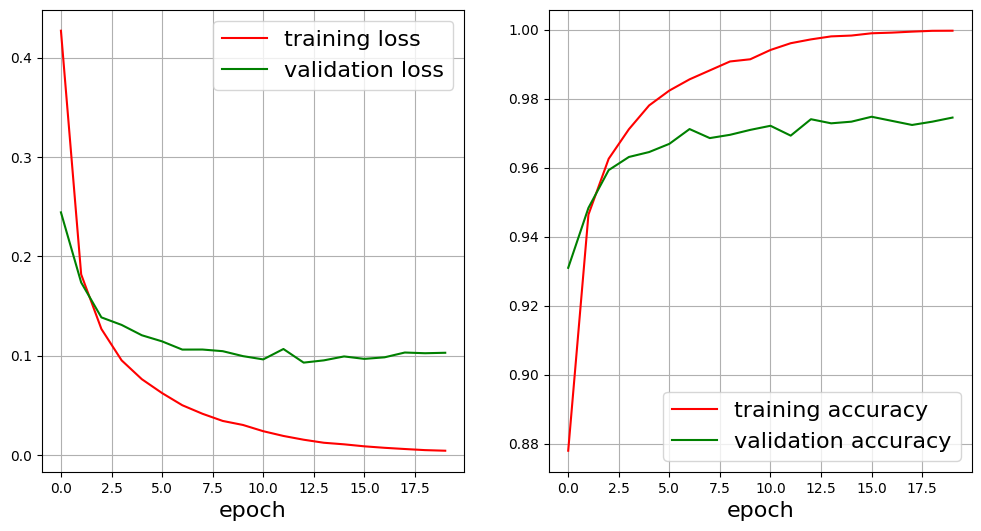

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-r', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-g', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-r', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

In [12]:
import tensorflow as tf
tf.saved_model.save(model, "./model/saved_model")

INFO:tensorflow:Assets written to: ./model/saved_model/assets


INFO:tensorflow:Assets written to: ./model/saved_model/assets


In [13]:
! rm -rf cleaned